# Fine tuning BERT for Text Classification of coronavirus tweets text classification

*  Author:       Jafet Israel Sierra Lagos
*  Last_update:  01-06-2022

### libraries

In [ ]:
! pip install -q -U "tensorflow-text==2.8.*"
! pip install tensorflow-addons
! pip install lightgbm
! pip install xgboost
#Basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from collections import Counter
#sklearn
import sklearn 
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection  import StratifiedKFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
#NLTK
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
#Boosting
import xgboost as xgb
import lightgbm as lgb
#SMOTE
from imblearn.over_sampling import SMOTE
#Tensorflow
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten, BatchNormalization
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
df = pd.read_csv('Corona_NLP_train.csv', encoding = "ISO-8859-1")

In [ ]:
df['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [ ]:
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

### text preprocessing

In [ ]:
def clean_text(text):
  mention_pattern = r'@\S+' 
  hasht_pattern = r'#\S+' 
  url_pattern = r'http.\S+' 
  punctuation = r'[^\w\s]'
  return re.sub(f'({mention_pattern})|({hasht_pattern})|({url_pattern})|({punctuation})','',text)

def delete_stop_words(text):
  rta = [word for word in text.split(' ') if word not in stopwords.words('english')]
  return ' '.join(rta)

In [ ]:
df['text'] = df['OriginalTweet'].apply(clean_text).apply(delete_stop_words).apply(lambda x: x.lower())

In [ ]:
df[['text','OriginalTweet']].head()

,text,OriginalTweet
0,,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1,advice talk neighbours family exchange phone n...,advice Talk to your neighbours family to excha...
2,coronavirus australia woolworths give elderly ...,Coronavirus Australia: Woolworths to give elde...
3,my food stock one empty\r\r\n\r\r\nplease dont...,My food stock is not the only one which is emp...
4,me ready go supermarket outbreak\r\r\n\r\r\nn...,"Me, ready to go at supermarket during the #COV..."


In [ ]:
X = df['text']
y_base_line = df['Sentiment']
df = pd.get_dummies(df,columns=['Sentiment']) 
y = df[['Sentiment_Extremely Negative', 'Sentiment_Extremely Positive',
       'Sentiment_Negative', 'Sentiment_Neutral', 'Sentiment_Positive']]

## Baseline model

In [ ]:
vec = TfidfVectorizer(min_df=15,max_df=30)
X_ = vec.fit_transform(df['text'])
X_.shape

(41157, 1860)

In [ ]:
smote = SMOTE ()
#Aplicamos oversampling
X_over, y_over = smote.fit_resample(X_,y_base_line)
number_per_class = dict(Counter(y_over))
number_per_class

{'Extremely Negative': 11422,
 'Extremely Positive': 11422,
 'Negative': 11422,
 'Neutral': 11422,
 'Positive': 11422}

In [13]:
kfold_over = StratifiedKFold(10,shuffle=True)
clfs_over = [
        RandomForestClassifier(),
        SVC(),
        lgb.LGBMClassifier()
]
cv_results_over = []

for classifier in clfs_over:
  cv_results_over.append(cross_val_score(classifier,X_over,y_over,scoring='accuracy',cv=kfold_over))

means_acc_over = []
stds_acc_over = []
classifiers_acc_over = ['rf','SVM','lightGBM']#,'ExtraTreesClf']
for result in cv_results_over:
  means_acc_over.append(result.mean())
  stds_acc_over.append(result.std())

rta_over = {
    'cv_accuracy': means_acc_over,
    'cv_stds': stds_acc_over,
    'Algorithm':classifiers_acc_over
}
rta_df_over = pd.DataFrame.from_dict(rta_over)
rta_df_over

,cv_accuracy,cv_stds,Algorithm
0,0.380249,0.006976,rf
1,0.383523,0.006702,SVM
2,0.321800,0.003960,lightGBM


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


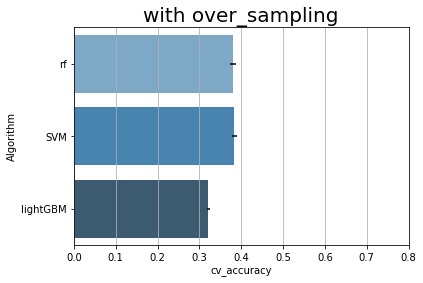

In [14]:
ax = sns.barplot('cv_accuracy','Algorithm',palette="Blues_d",data=rta_df_over,**{'xerr':stds_acc_over})
ax.grid(axis='x')
plt.title('with over_sampling',fontdict={'fontsize':20})
plt.xlim(0,0.8)
plt.savefig('cv-resumen-over.png')
plt.show()

## first model

In [15]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder    = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4',trainable=True)

In [16]:
#Model
#bert layers
input_l        = Input(shape=(),dtype=tf.string,name='text_input')
preprocessed_l = bert_preprocess(input_l)
embedding_l    = bert_encoder(preprocessed_l)
#NN layers
drop_l1        = Dropout(0.3)(embedding_l['pooled_output'])
batch_l1       = BatchNormalization()(drop_l1)
dense_l1       = Dense(256, activation='relu', kernel_regularizer='l2' ,kernel_initializer='he_normal', bias_initializer='ones')(batch_l1)
drop_l2        = Dropout(0.3)(dense_l1)
batch_l2       = BatchNormalization()(drop_l2)
dense_l_out    = Dense(5,activation='softmax',name='output')(batch_l2)

model = tf.keras.Model(inputs=[input_l],outputs=[dense_l_out])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text_input[0][0]']             
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [18]:
def scheduler(epoch,lr):
    return lr*tf.math.exp(-0.5)

def checkpoint_best():
  path = 'checkpoint_best/checkpoint'
  checkp = ModelCheckpoint(
      filepath=path,
      save_weights_only=True,
      save_freq='epoch',
      monitor='val_categorical_accuracy',
      save_best_only=True,
      verbose=1
  )
  return checkp
call = [
        tf.keras.callbacks.LearningRateScheduler(scheduler),
        tf.keras.callbacks.EarlyStopping(monitor="val_categorical_accuracy",patience=1),
        checkpoint_best()
        ]

opt = tf.keras.optimizers.Adam(2e-5)
Metrics = [
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           tf.keras.metrics.CategoricalAccuracy()
]
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=Metrics
)

In [19]:
history = model.fit(X,y,epochs=5, validation_split=0.2,batch_size=16,callbacks=call)

Epoch 1/5
2058/2058 [==============================] - ETA: 0s - loss: 6.4164 - precision: 0.5108 - recall: 0.3832 - categorical_accuracy: 0.4578
Epoch 1: val_categorical_accuracy improved from -inf to 0.72072, saving model to checkpoint_best/checkpoint
2058/2058 [==============================] - 700s 329ms/step - loss: 6.4164 - precision: 0.5108 - recall: 0.3832 - categorical_accuracy: 0.4578 - val_loss: 5.4967 - val_precision: 0.7340 - val_recall: 0.6991 - val_categorical_accuracy: 0.7207 - lr: 1.2131e-05
Epoch 2/5
2058/2058 [==============================] - ETA: 0s - loss: 5.4301 - precision: 0.7274 - recall: 0.6616 - categorical_accuracy: 0.7024
Epoch 2: val_categorical_accuracy improved from 0.72072 to 0.79203, saving model to checkpoint_best/checkpoint
2058/2058 [==============================] - 675s 328ms/step - loss: 5.4301 - precision: 0.7274 - recall: 0.6616 - categorical_accuracy: 0.7024 - val_loss: 5.0081 - val_precision: 0.7986 - val_recall: 0.7827 - val_categorical_acc

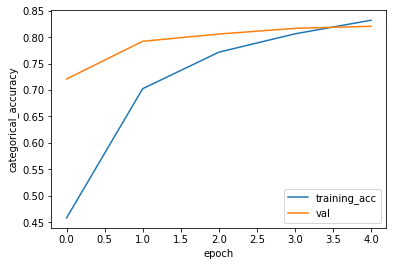

In [20]:
'''
#plotting the loss for training and validation set
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss vs epochs')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training','val'], loc='upper right')
plt.show()
'''
#plotting the accuracy for both, training and validation set. 
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.xlabel('epoch')
plt.ylabel('categorical_accuracy')
plt.legend(['training_acc','val'])
plt.show()

## Test-Data

In [21]:
df_test = pd.read_csv('Corona_NLP_test.csv', encoding = "ISO-8859-1")

In [22]:
df_test['text'] = df_test['OriginalTweet'].apply(clean_text).apply(lambda x : x.lower())

In [23]:
df_test = pd.get_dummies(df_test,columns=['Sentiment']) 
y_true = df_test[['Sentiment_Extremely Negative', 'Sentiment_Extremely Positive',
       'Sentiment_Negative', 'Sentiment_Neutral', 'Sentiment_Positive']]

In [24]:
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,text,Sentiment_Extremely Negative,Sentiment_Extremely Positive,Sentiment_Negative,Sentiment_Neutral,Sentiment_Positive
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,trending new yorkers encounter empty supermark...,1,0,0,0,0
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,when i couldnt find hand sanitizer at fred mey...,0,0,0,0,1
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,find out how you can protect yourself and love...,0,1,0,0,0
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,buying hits city as anxious shoppers stock u...,0,0,1,0,0
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,one week everyone buying baby m...,0,0,0,1,0


In [25]:
y_pred = model.predict(df_test['text'])

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [27]:
rta = np.argmax(y_pred,axis=-1)

In [28]:
y_true_copy = np.argmax(y_true.to_numpy(),axis=-1)

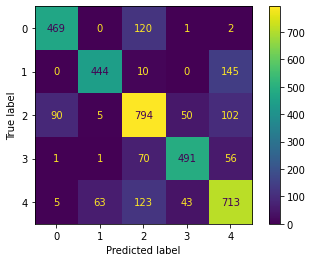

In [29]:
cm = confusion_matrix(y_true_copy, rta)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [30]:
from sklearn.metrics import f1_score
f1_score(y_true_copy, rta, average='weighted')

0.7678838843933101